In [1]:
from qiskit import *
from torchvision import datasets, transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, normalize
from qiskit.circuit import ParameterVector, Parameter
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit import execute
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector
from sklearn.decomposition import PCA

In [66]:
# Concentrating on the first 100 samples
n_samples = 50

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))
# Leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

x_train = np.array([X_train[i][0].numpy() for i in idx])
y_train = np.array([X_train[i][1] for i in idx])

x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [67]:
n_samples = 10

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

x_test = np.array([X_test[i][0].numpy() for i in idx])
y_test = np.array([X_test[i][1] for i in idx])

x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [68]:
print(x_train.shape)
print(x_test.shape)

h = x_train.shape[2]
w = x_train.shape[3]

x_train = x_train.reshape(-1,h,w)
x_test = x_test.reshape(-1,h,w)

print(x_train.shape)
print(x_test.shape)

(100, 1, 28, 28)
(20, 1, 28, 28)
(100, 28, 28)
(20, 28, 28)


In [69]:
def display_images(x, y):
    n_samples_show = 10
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    while n_samples_show > 0:
        image, target = x[n_samples_show], y[n_samples_show]

        axes[n_samples_show - 1].imshow(image, cmap='gray')
        axes[n_samples_show - 1].set_xticks([])
        axes[n_samples_show - 1].set_yticks([])
        axes[n_samples_show - 1].set_title(format(target))

        n_samples_show -= 1

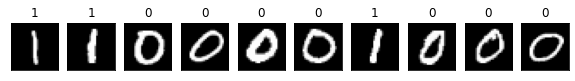

In [70]:
display_images(x_train, y_train)

In [71]:
x_train = x_train.reshape(-1,h*w)
x_test = x_test.reshape(-1,h*w)

In [72]:
n_components = 16
pca = PCA(n_components)
pca.fit(x_train)
print("Cumulative sum for train:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_train = pca.transform(x_train)

pca.fit(x_test)
print("Cumulative sum for test:", np.cumsum(pca.explained_variance_ratio_ * 100)[-1])
x_test = pca.transform(x_test)

Cumulative sum for train: 83.05244
Cumulative sum for test: 98.82273


In [73]:
print(x_train.shape)
print(x_test.shape)

(100, 16)
(20, 16)


In [74]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [75]:
# threshold = 0

# x_train = np.array(x_train > threshold, dtype=np.float32)
# x_test = np.array(x_test > threshold, dtype=np.float32)

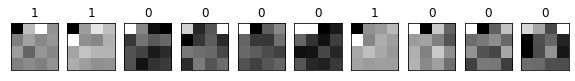

In [76]:
display_images(x_train.reshape(-1,4,4),y_train)

In [17]:
print(x_train.max(),x_train.min())

0.86018723 -0.89008534


In [77]:
def cirq_layer(qc, readout, data_qubits, gate_name):
    theta_list = ParameterVector('θ' + gate_name, length=len(data_qubits))
    if gate_name == 'xx':
        for i in data_qubits:
            qc.rxx(theta_list[i-1], i, readout)
    elif gate_name == 'zz':
        for i in data_qubits:
            qc.rzz(theta_list[i-1], i, readout)
    else:
        raise ValueError("gate name must be either xx or zz")
    return qc

In [78]:
# cluster state
def cluster_state_circuit(bits):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    qc.h(bits)
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        qc.cz(this_bit, next_bit)
    return qc

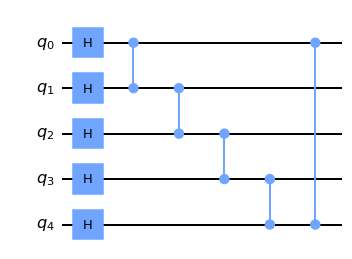

In [79]:
cluster_state_circuit(5).draw('mpl')

In [80]:
def one_qubit_unitary(thetas):
    qc = QuantumCircuit(1)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc

def two_qubit_unitary(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [1])
    qc.rzz(thetas[6],0, 1)
    qc.ryy(thetas[7],0, 1)
    qc.rxx(thetas[8],0, 1)
    qc = qc.compose(one_qubit_unitary(thetas[9:12]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[12:]), [1])
    return qc


def two_qubit_pool(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [1])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [0])
    qc.cnot(0,1)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]).inverse(), [1])
    return qc

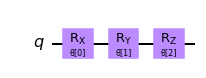

In [53]:
one_qubit_unitary(ParameterVector('θ', length=3)).draw('mpl')

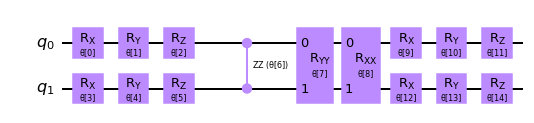

In [54]:
two_qubit_unitary(ParameterVector('θ', length=15)).draw('mpl')

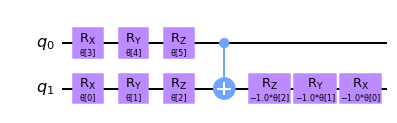

In [57]:
two_qubit_pool(ParameterVector('θ', length=6)).draw('mpl')

In [62]:
def quantum_conv_circuit(bits, thetas):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    for first, second in zip(bits[0::2], bits[1::2]):
        qc = qc.compose(two_qubit_unitary(thetas), [first,second])
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        qc = qc.compose(two_qubit_unitary(thetas), [first, second])
    return qc

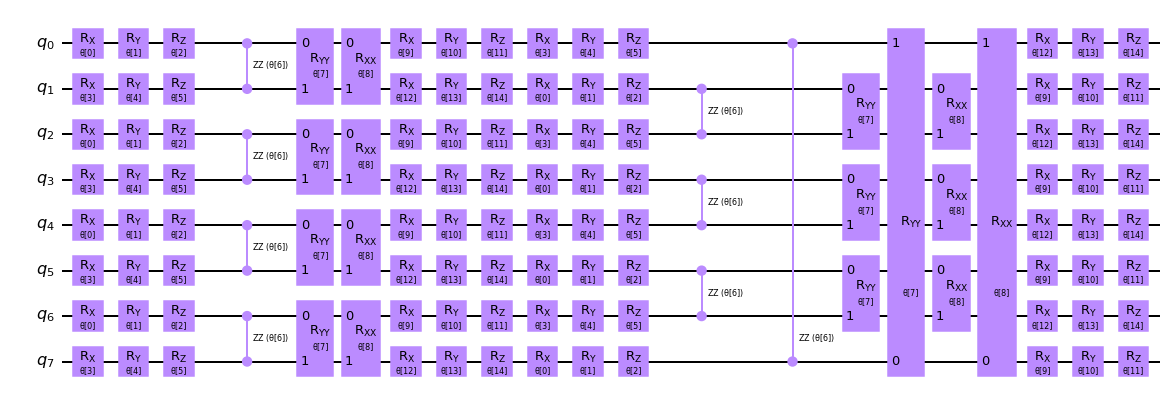

In [63]:
quantum_conv_circuit(8, ParameterVector('θ', length=15)).draw('mpl')

In [64]:
def quantum_pool_circuit(sources, sinks, thetas):
    qc = QuantumCircuit(len(sources) + len(sinks))
    for source, sink in zip(sources, sinks):
        qc = qc.compose(two_qubit_pool(thetas), [source, sink])
    return qc

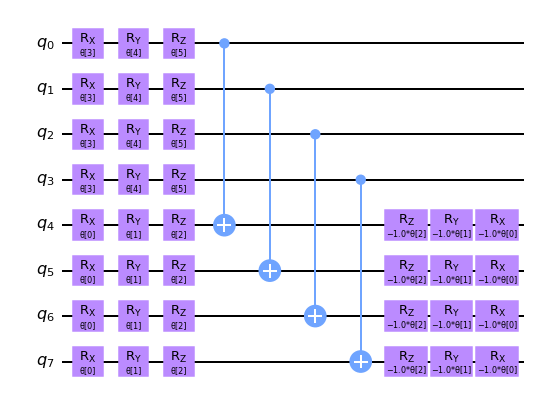

In [65]:
quantum_pool_circuit(list(range(4)), list(range(4,8)), ParameterVector('θ', length=6)).draw('mpl')

In [137]:
n = n_components
backend = AerSimulator()

# Data encoding
in_thetas = ParameterVector('θ_in', length=n)
feature_map = QuantumCircuit(n,1)
for i in range(n):
    feature_map.rx(in_thetas[i], i)

# cluster state
cluster_qc = cluster_state_circuit(n)

# variational circuit
thetas = ParameterVector('θ', length=64)
Range = list(range(n))
var_form = QuantumCircuit(n,1)
var_form = var_form.compose(quantum_conv_circuit(n,thetas[0:15]), Range)
var_form = var_form.compose(quantum_pool_circuit(Range[:8], Range[8:], thetas[15:21]), Range)
var_form = var_form.compose(quantum_conv_circuit(n//2,thetas[21:36]), Range[8:])
var_form = var_form.compose(quantum_pool_circuit(Range[:4], Range[4:8], thetas[36:42]), Range[8:])
var_form = var_form.compose(quantum_conv_circuit(n//4,thetas[42:57]), Range[12:])
var_form = var_form.compose(quantum_pool_circuit(Range[:3], [Range[3]], thetas[57:63]), Range[12:])

circuit = QuantumCircuit(n,1)
circuit = circuit.compose(cluster_qc)
circuit = circuit.compose(feature_map)
circuit = circuit.compose(var_form)
circuit.measure(15, 0)

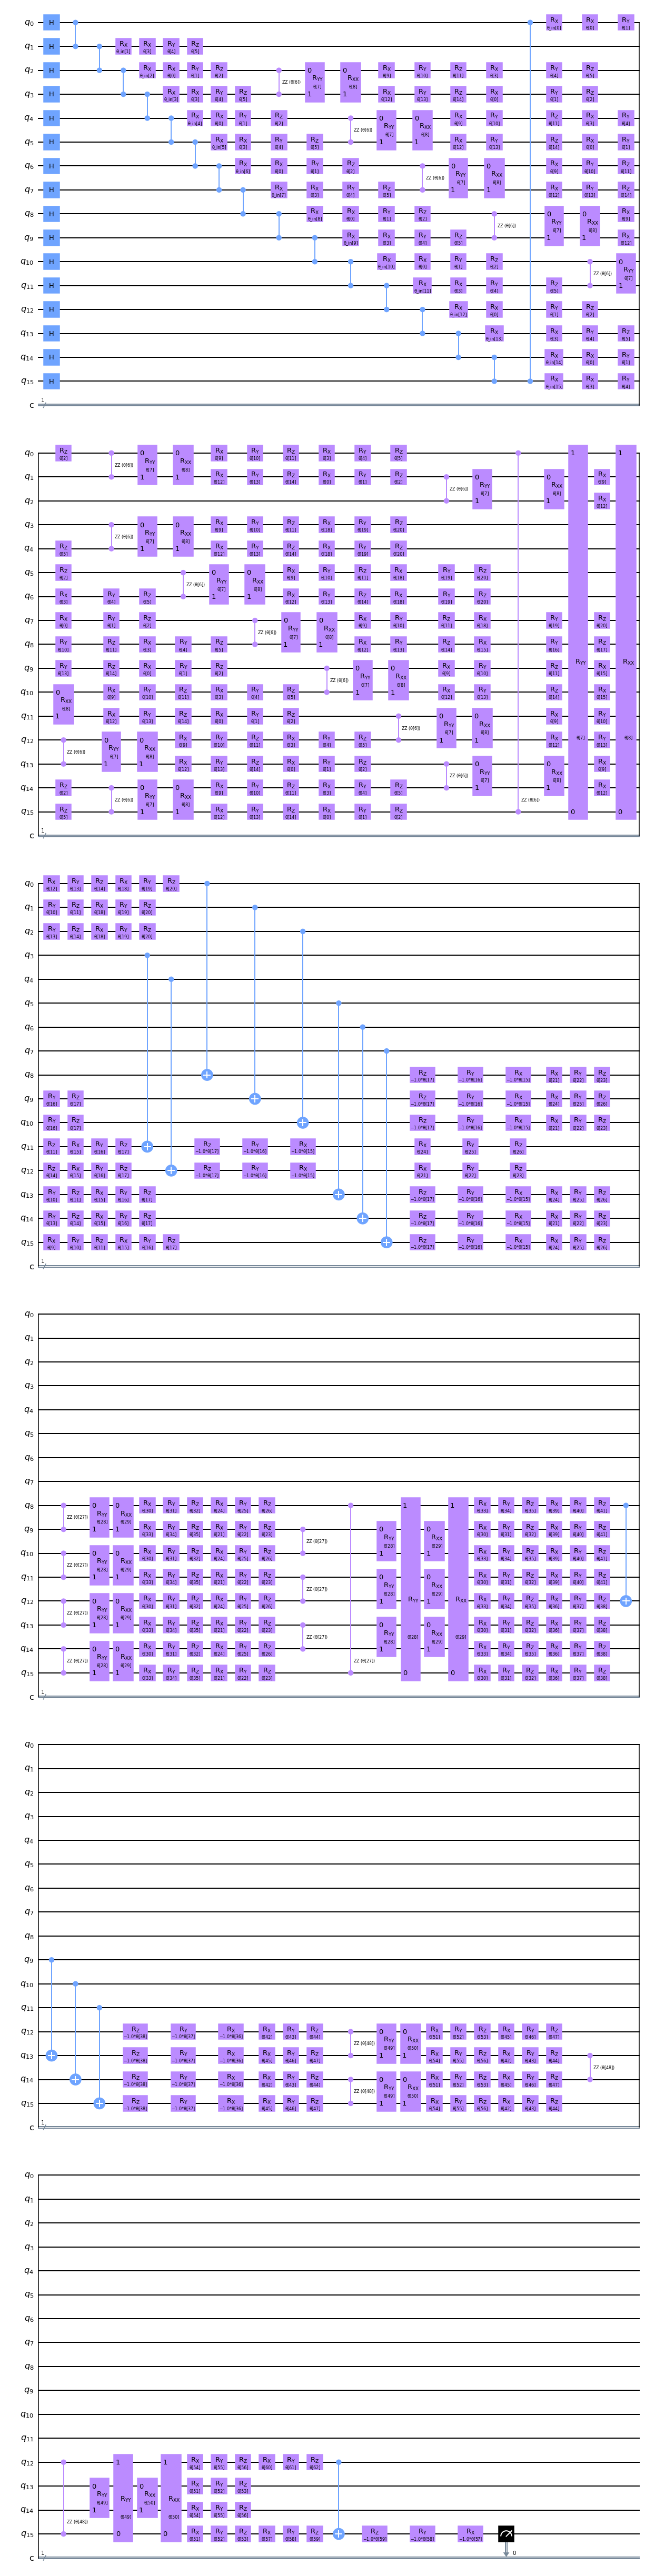

In [138]:
circuit.draw('mpl')

In [139]:
var_form.num_parameters

63

In [140]:
def circuit_parameters(x, variational):
    parameters = {}
    for i, p in enumerate(feature_map.parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.parameters):
        parameters[p] = variational[i]
    return parameters

In [141]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 1
    else:
        return 0

In [142]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [143]:
def classification_probability(data, variational):
    qc_list = [circuit.assign_parameters(circuit_parameters(d,variational)) for d in data]
    results =  execute(qc_list, backend).result()
    classification = [label_probability(results.get_counts(c)) for c in qc_list]
    return classification

In [144]:
costs = []
accuracies = []

In [145]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))

def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0
    predictions = []
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
        if classification[0] > classification[1]:
            predictions.append(0)
        else:
            predictions.append(1)
    cost /= len(data)
    costs.append(cost)
    acc = sum(predictions == labels)/len(labels)
    accuracies.append(acc)
    print('cost:', np.around(cost,4), 'acc: ',np.around(acc, 4))
    return cost

In [146]:
optimizer = COBYLA(maxiter=100)

initial_point = np.random.random(circuit.num_parameters)

objective_function = lambda variational: cost_function(x_train,
                                                       y_train,
                                                       variational)

In [147]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

cost: 0.6937 acc:  0.46


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process ForkProcess-9:
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/site-packages/qiskit/tools/parallel.py", line 149, in parallel_map
    future = executor.map(_task_wrapper, param)
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/concurrent/futures/_base.py", line 623, in __exit__
    self.shutdown(wait=True)
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/concurrent/futures/process.py", line 681, in shutdown
    self._queue_management_thread.join()
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.p

  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()

KeyboardInterrupt

  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/gopald/.pyenv/versions/3.7.13/lib/python3.7/site-packages/qiskit/circuit/register.py", line 235, in __setstate__
    def __setstate__(self, state):
KeyboardInterrupt


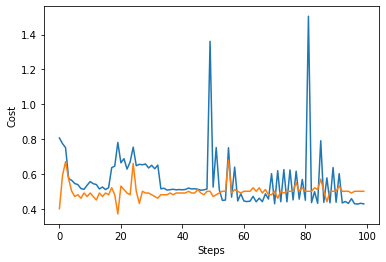

In [434]:
fig = plt.figure()
plt.plot(costs)
plt.plot(accuracies)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [435]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

accuracy, prediction = score_classifier(x_test, y_test, opt_var)
accuracy

0.5